In [1]:
import os

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Activation,
    Conv2D,
    Conv2DTranspose,
    BatchNormalization,
    AveragePooling2D,
    Flatten,
    Lambda,
    add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MSE, BinaryCrossentropy
from tensorflow.keras import backend as K

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## introduction
- VAE (Variational Autoencoder) is a generative model like GAN
- But,
    - GAN focuces on the model which approximates input data distribution
    - VAE focuces on the model which can decode input data distribution on the continuous latent space
    
- VAE vs Autoencoder
    - They both learn a latent-space and try to reconstruct the input data distribution|
    - But, VAE's latent-space is continuous and decoder is used as a generative model

## notations

* $x \sim P_\theta (x)$
    - real data distribution
    - $\theta$: parameter to be learned
        - e.g.
            - face
            - hand-written number
            
* $P_\theta (x, z)$
    - join distribution of input $x$ and latent variable $z$
    - not a part of input data, but encode observable features from input data
        - e.g.
            - face data: facial expression, hair shape, hair color, sex, $\cdots$
            - mnist: number, hand-writting

## Variational Inference
* $P_\theta (x) = \int P_\theta (x, z) dz$
    - **usually intractable!**
    - Note that
\begin{align*}
P_\theta (x) &= \int P_\theta (x, z) dz \\
&= \int P_\theta (x|z) P(z) dz \quad \quad \quad \quad (1)\\
&= \int P_\theta (z|x) P(x) dz \quad \quad \quad \quad (2)\\
\end{align*}
        - (1) is inappropriate since it does not give any restrictions on $z$
        - (2) is also hard to solve
        - So, VAE aims to approximate **$P_\theta(z|x)$** while finding tractable conditional distribution (see below)

* $Q_\phi (z|x) \approx P_\theta (z|x)$
    - $Q_\phi (z|x)$ is usuaully multivariate gaussian 
    $$Q_\phi (z|x) = N(z; \mu (x), diag(\sigma (x)))$$
    
* How to measure the distance between $Q_\phi(z|x)$ and $P_\theta(z|x)$?
* $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (z|x) \big]$
    - $Q_\phi(z|x)$: generates $z$ from input $x$
    - $P_\theta(x|z)$: reconstruct $x$ from latent $z$
        - similiar to decoder in autoencoder

* Plugin $P_\theta (z|x) = \frac{P_\theta(x|z) P_\theta (z)}{P_\theta(x)}$ gives
    - $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (x|z) - log P_\theta (z)\big] + log P_\theta (x)$
    
* Re-arranging above equation gives
$$log P_\theta (x) - D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log P_\theta (x|z) - D_{KL} (Q_\phi (z|x) || P_\theta(z))\big] \quad \quad \quad \quad (3)$$
    - LHS is called **variational lower bound** OR **ELBO (evidence lower bound)**

## CVAE

* key idea in CVAE is similar to CGAN
* CVAE modifies equation (3) as below
* $log P_\theta (x|c) - D_{KL}(Q_\phi (z|x,c) || P_\theta (z|x, c)) = E_{z\sim Q} \big[ logP_\theta(x|z, c) \big] - D_{KL} (Q_\phi(z|x, c || P_\theta (z|c)))$

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]    
    dim = K.int_shape(z_mean)[1]
    
    # sample from N(0, I)
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5*z_log_var)*epsilon

## load mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# number of labels
num_labels = len(np.unique(y_train))

img_size = x_train.shape[1]

In [5]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

## network parameter

In [6]:
input_shape = (img_size, img_size, 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 50

## build encoder

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')

x = Dense(img_size*img_size)(y_labels)
x = Reshape((img_size, img_size, 1))(x)
x = K.concatenate([inputs, x])

In [8]:
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [9]:
# shape needed to build decoder
shape = K.int_shape(x)

In [10]:
x = Flatten()(x)
x = Dense(16, activation='relu')(x)

In [11]:
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [12]:
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

## encoder model instance

In [13]:
encoder = Model([inputs, y_labels], [z_mean, z_log_var, z], name='encoder')

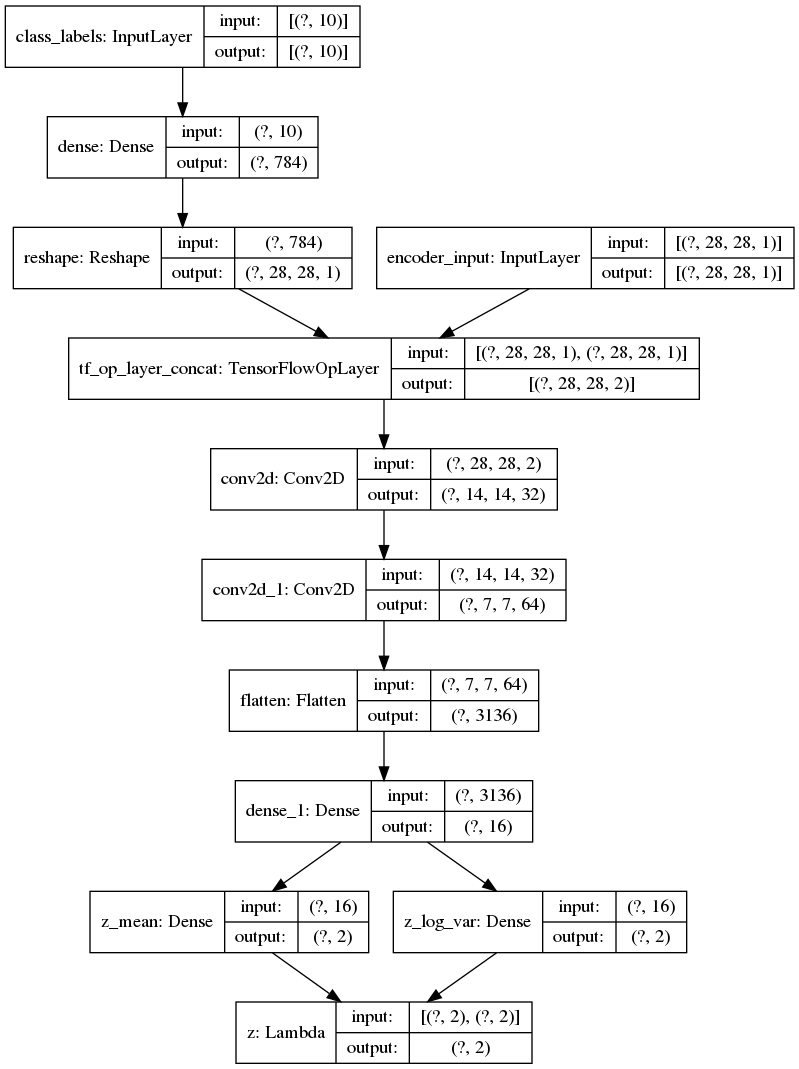

In [14]:
plot_model(encoder, to_file='../figures/cvae_cnn_encoder.png', show_shapes=True)

## build decoder

In [15]:
latent_inputs = Input(shape=(latent_dim, ), name='z_sampling')

In [16]:
x = K.concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [17]:
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

In [18]:
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

## decoder model instance

In [19]:
decoder = Model([latent_inputs, y_labels], outputs, name='decoder')

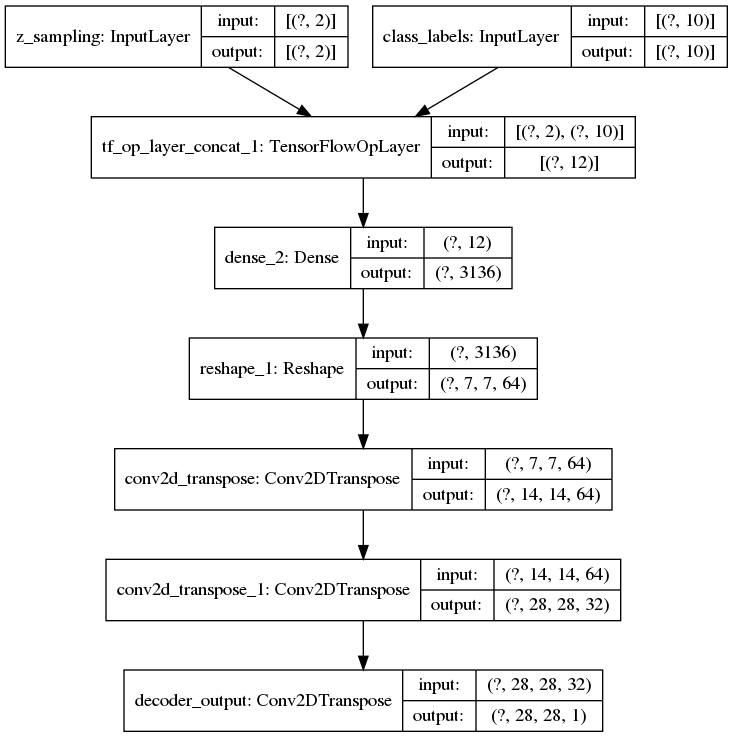

In [20]:
plot_model(decoder, to_file='../figures/cvae_cnn_decoder.png', show_shapes=True)

## VAE model instance

In [21]:
# note that encoder returns z_mean, z_sig, z
# and we wants to generate image using a decoder which requires z as inputs
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae_cnn')

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input:0


## define loss function

In [22]:
beta = 1.0

In [23]:
reconstruction_loss = MSE(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= img_size*img_size

In [24]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta

In [25]:
cvae_loss = K.mean(reconstruction_loss + kl_loss)

In [26]:
cvae.add_loss(cvae_loss)

In [27]:
cvae.compile(optimizer='rmsprop')

In [28]:
cvae.summary()

Model: "cvae_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 77988       encoder_input[0][0]              
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    96449       encoder[1][2]             

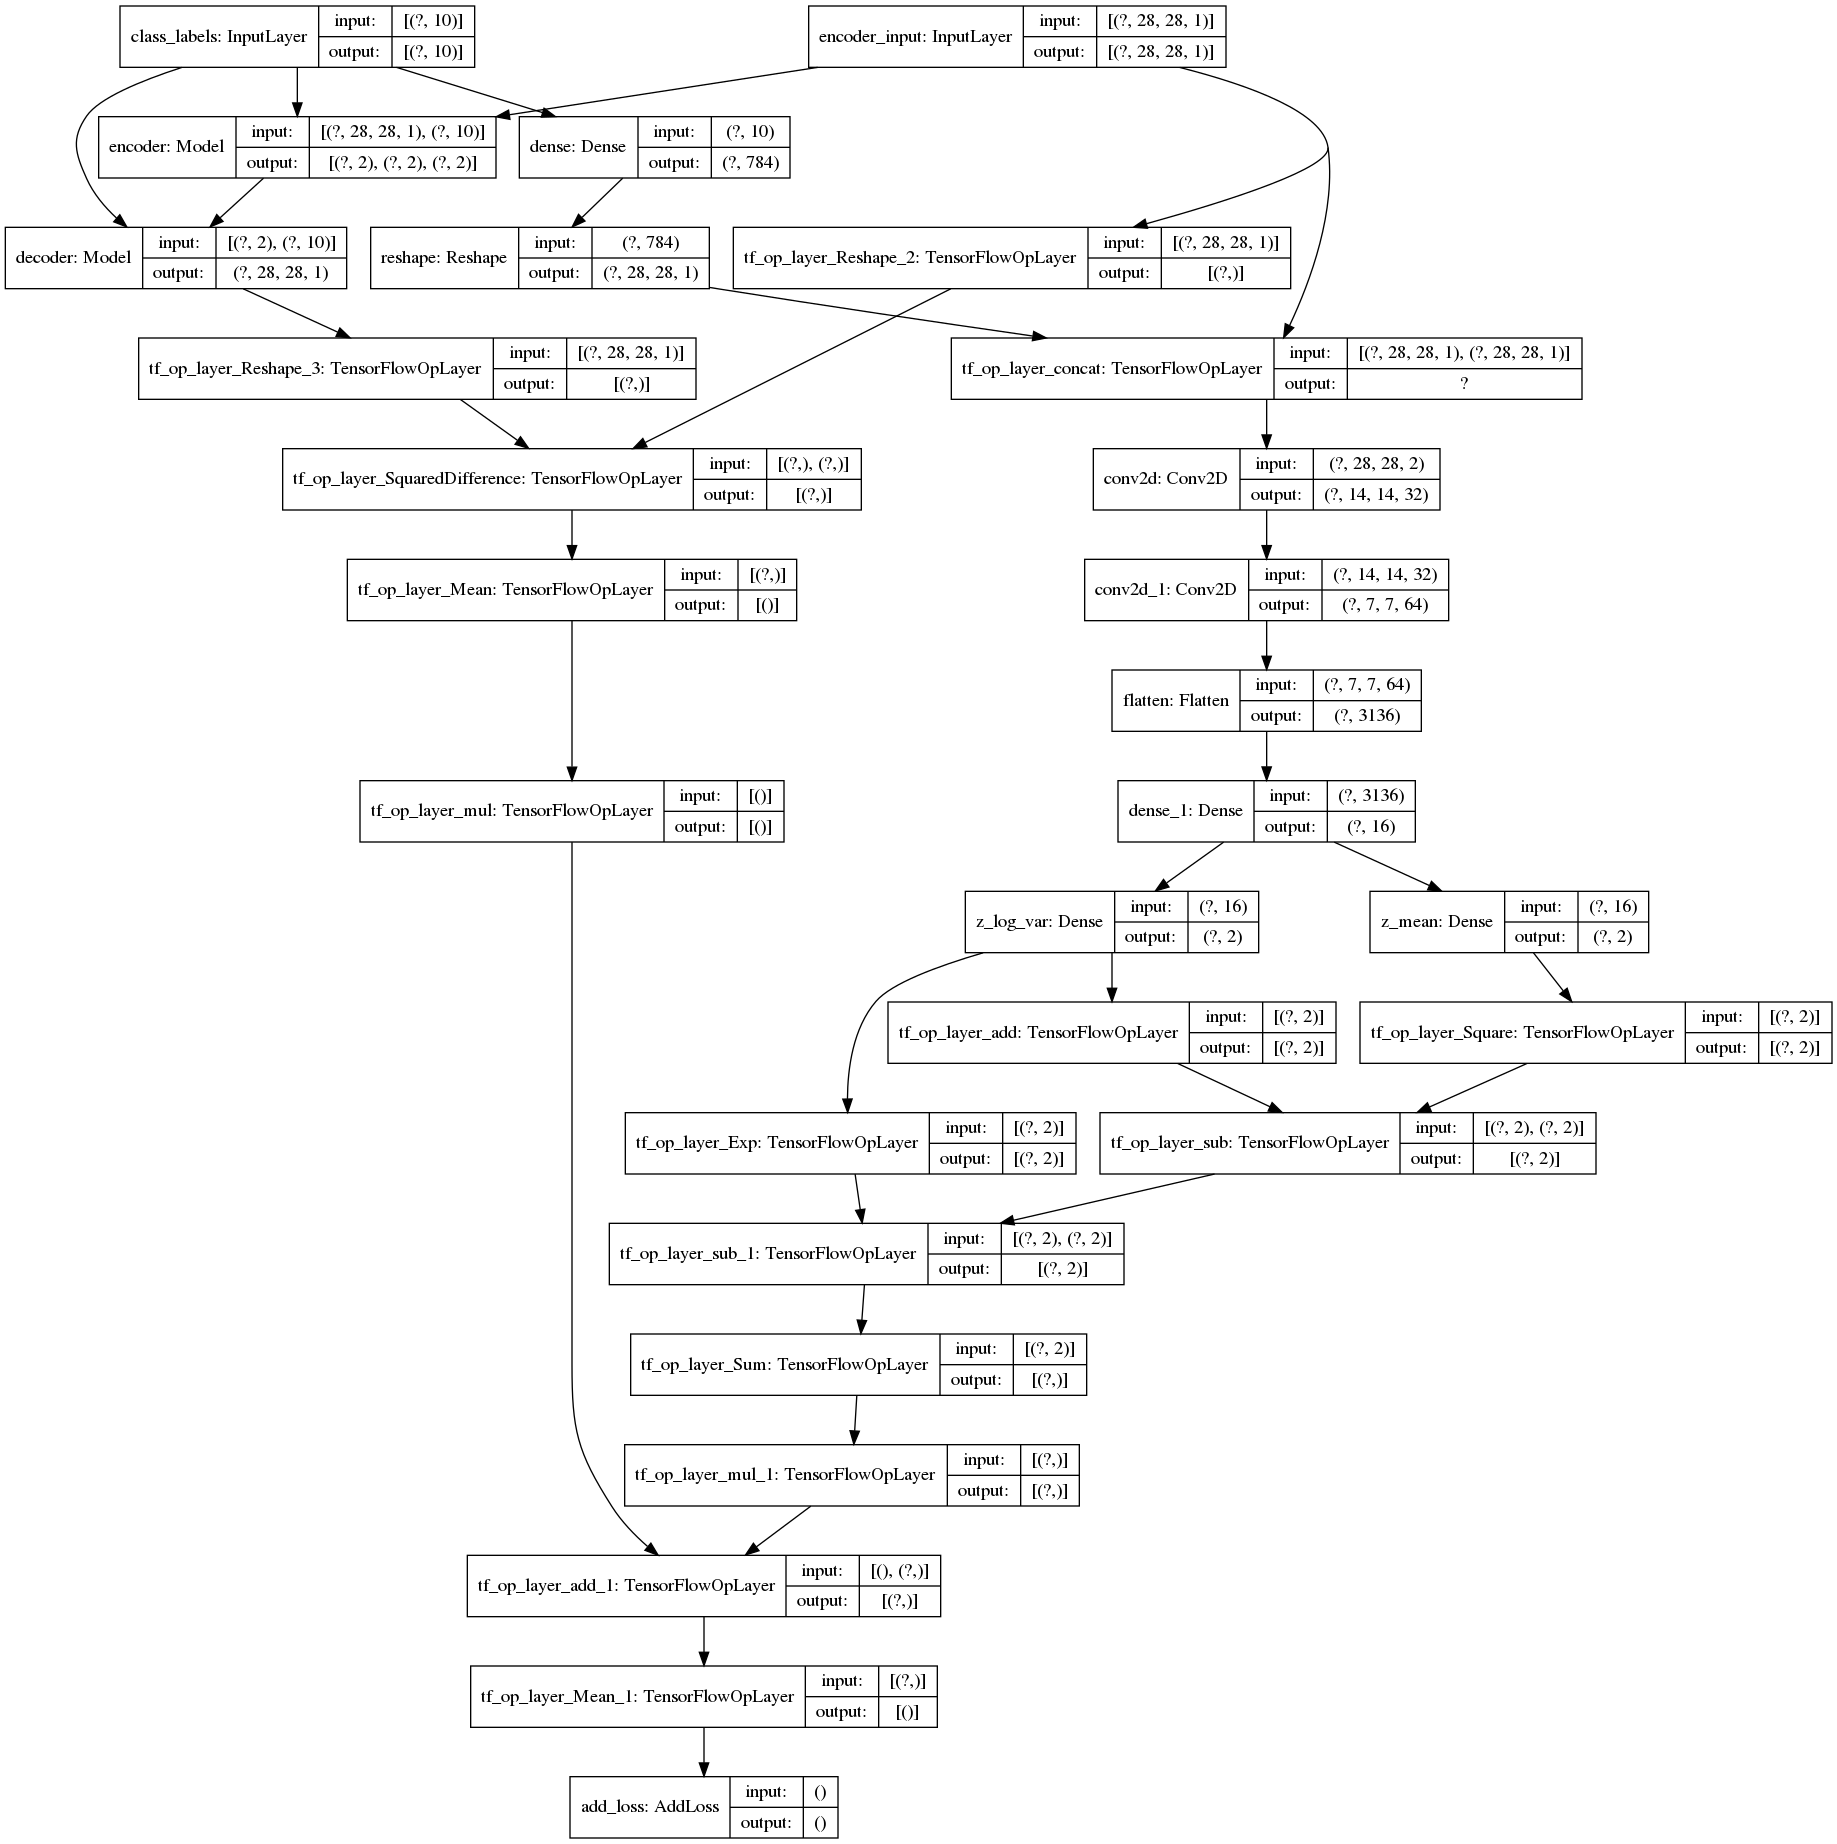

In [29]:
plot_model(cvae, to_file='../figures/cvae_cnn.png', show_shapes=True)

In [30]:
save_path = '../models/cvae_cnn'

In [31]:
# # takes about 500 sec (10secs per epoch)
# cvae.fit([x_train, to_categorical(y_train)],
#          epochs=epochs,
#          batch_size=batch_size,
#          validation_data=([x_test, to_categorical(y_test)], None))

# cvae.save_weights(save_path)

In [32]:
cvae.load_weights(save_path)

In [36]:
y_pred = cvae.predict([x_test, to_categorical(y_test)])

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def draw_figure(i):
    
    fig, ax_arr = plt.subplots(1, 2)
    
    imgs = [x_test[i].reshape(28, 28), y_pred[i].reshape(28, 28)]
    labels = ['input', 'output']
    for idx, img in enumerate(imgs):
        ax = ax_arr[idx]
        ax.imshow(img)
        ax.set_title(labels[idx])
        ax.axis('off')

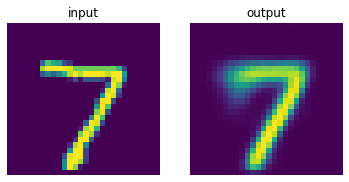

In [39]:
draw_figure(0)

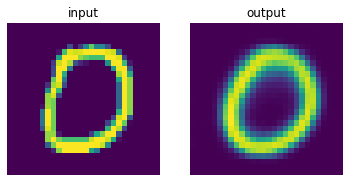

In [40]:
draw_figure(10)

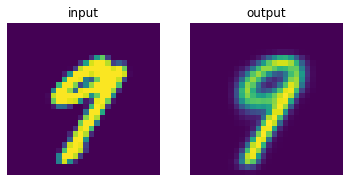

In [41]:
draw_figure(20)

## plot results

In [42]:
import pandas as pd

In [43]:
xmin = ymin = -4
xmax = ymax = +4

In [77]:
mean_fig_name = "../figures/cvae_cnn_mean.png"
digit_latent_fig_name = "../figures/cvae_cnn_digit_latent_digit_{}.png"

In [46]:
mu, sig, z = encoder.predict([x_test, to_categorical(y_test)], batch_size=batch_size)

In [47]:
mu_samp = mu[0::10]
y_test_samp = y_test[0::10]

In [48]:
labels = np.unique(y_test_samp)
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
color_dict = {
    l: colors[i] for i, l in enumerate(labels)
}

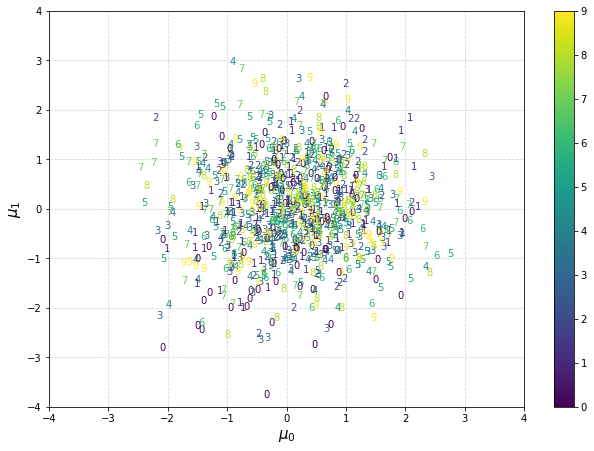

In [49]:
fig, ax = plt.subplots(1, 1)
ax.grid(linestyle='--', alpha=0.5)

fig.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

cmap = ax.scatter(mu_samp[:, 0], mu_samp[:, 1], marker="")
cmap.set_clim(0, 9)
for i, digit in enumerate(y_test_samp):
    ax.annotate(digit, (mu_samp[i, 0], mu_samp[i, 1]), color=color_dict[digit])
    
ax.set_xlabel('$\mu_0$', fontsize=15)
ax.set_ylabel('$\mu_1$', fontsize=15)

fig.subplots_adjust(right=1.5, top=1.5)
fig.colorbar(cmap)

fig.savefig(mean_fig_name)

In [65]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [90]:
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

# set target number here
target_digit = [9]
y_label = np.eye(num_labels)[target_digit]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])                
        x_decoded = decoder.predict([z_sample, y_label])
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

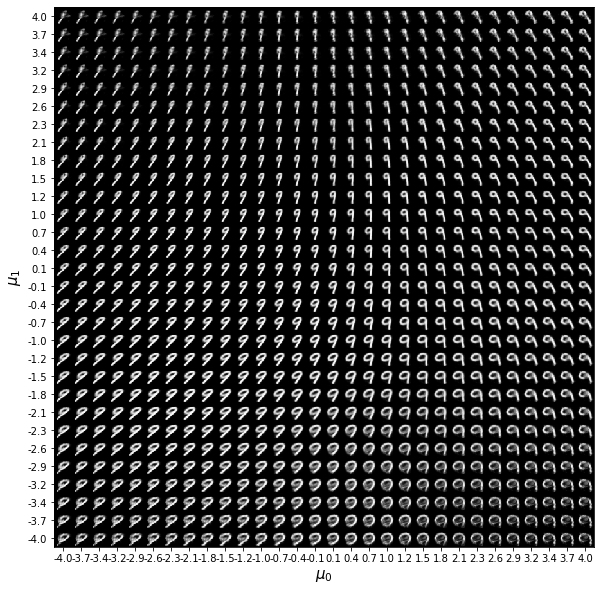

In [91]:
fig, ax = plt.subplots()

start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

ax.set_xticks(pixel_range)
ax.set_yticks(pixel_range)
ax.set_xticklabels(sample_range_x)
ax.set_yticklabels(sample_range_y)

ax.set_xlabel("$\mu_0$", fontsize=15)
ax.set_ylabel("$\mu_1$", fontsize=15)

ax.imshow(figure, cmap='Greys_r')
fig.subplots_adjust(right=2, top=2)

plt.savefig(digit_latent_fig_name.format(target_digit[0]))